# Домашнее задание №3

Машинное обучение, ФИВТ, Весна 2018

## Часть 1. Теоретические задачи

### Задача 1 (10% баллов)

Предположим, что мы решаем задачу бинарной классификации и что у нас есть три алгоритма $b_1(x)$, $b_2(x)$ и $b_3(x)$, каждый из которых ошибается с вероятностью p. Мы строим композицию взвешенным голосованием: алгоритмам присвоены значимости $w_1$, $w_2$ и $w_3$, и для вынесения вердикта суммируются значимости алгоритмов, проголосовавших за каждый из классов:

$$a_0 = \sum_{i=1}^3 w_i [b_i(x)=0]$$
$$a_1 = \sum_{i=1}^3 w_i [b_i(x)=1]$$


Объект $x$ относится к классу, для которого такая сумма оказалась максимальной. Например, если первые два алгоритма голосуют за класс $0$, а третий — за класс $1$, то выбирается класс $0$, если $w_1 + w_2 > w_3$, и класс $1$ в противном случае. Какова вероятность ошибки такой композиции этих трех алгоритмов, если:
1. $w_1 = 0.2, w_2 = 0.3, w_3 = 0.2$;
2. $w_1 = 0.2, w_2 = 0.5, w_3 = 0.2$? 

In [1]:
# Ваш ответ здесь

### Задача 2 (10% баллов)

Рассмотрим задачу бинарной классификации. Будем считать, что все алгоритмы из базового семейства возвращают ответы из отрезка $[0,1]$, которые можно интерпретировать как вероятности принадлежности объектов классу $1$. В качестве функции потерь возьмем отрицательный логарифм правдоподобия:
$$L(y,z) = -(y \log{z}+(1-y)\log{(1-z)})$$
В формуле $y$ - правильный ответ, $z$ - ответ алгоритма. Выпишите формулы для поиска базовых алгоритмов $b_n$ и коэффициентов $\gamma_n$ в градиентном бустинге.

In [2]:
# Ваш ответ здесь

### Задача 3 (10% баллов)

Известно, что на $n$-й итерации двухклассового метода AdaBoost
был выбран базовый классификатор, допускающий ошибку только на одном объекте $x_j$. Найдите нормированный вес $w_j^{(n+1)}$ при этом объекте на следующей итерации.

In [3]:
# Ваш ответ здесь

## Часть 2. Random Forest

In [4]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [5]:
warnings.simplefilter("ignore")

### Реализация (40%)

**Необходимо реализовать класс `RandomForest`** (для решения задачи классификации)

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    - `num_trees` - количество деревьев в лесе;
    - `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    - `max_features` - количество признаков, принимаемое к рассмотрению при разбиении (аналогичный параметр есть в sklearn имплементации). Параметр может принимать значения:
        - int - тогда рассматриваем max_features признаков при каждом разбиении;
        - float - max_features обозначает процент, int(max_features * n_features) признаков рассматривается при каждом разбиении;
        - “sqrt” - max_features=sqrt(n_features);
        - “log2” - max_features=log2(n_features);
        - None - max_features=n_features;
    - `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', по умолчанию - 'gini'); функции с подсчетом энтропийного и критерия Джини можно взять из предыдущего дз;
    
- класс имеет методы `fit` и `predict`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `RandomForest`, представляющий собой Random Forest, обученный по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов;

In [6]:
def bagging(X, y, size):
    indices = np.random.randint(0, len(y), size)
    sample_X, sample_y = X.iloc[indices], y.iloc[indices]
    return sample_X, sample_y

In [7]:
class RandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, num_trees, max_features, max_depth=None, criterion='gini'):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []
    
    def fit(self, X_train, y_train):
        for i in range(self.num_trees):
            sample_X, sample_y = bagging(X_train, y_train, len(y_train))
            clf = tree.DecisionTreeClassifier(criterion=self.criterion,
                                              max_depth=self.max_depth,
                                              max_features=self.max_features)
            clf.fit(sample_X, sample_y)
            self.trees += [clf]
            
        return self
    
    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0])
        
        for tree in self.trees:
            y_pred += tree.predict(X_test)
        
        return np.around(y_pred / self.num_trees)

### Тестирование (15%)

Загрузите датасет Wine Data Set (https://archive.ics.uci.edu/ml/datasets/wine). Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=42`. Попробуйте обучить Random Forest на предложенном датасете

In [8]:
columns = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash',
           'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols',
           'Proanthocyanins', 'Color intensity', 'Hue',
           'OD280/OD315 of diluted wines', 'Proline']

In [9]:
data = pd.read_csv('wine.data', names=columns)
data = data[columns[1:] + columns[0:1]]

In [10]:
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline,Class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1],
                                                    data.iloc[:, -1:],
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
rf = RandomForest(10, max_features='sqrt')
rf.fit(X_train, y_train)
accuracy = accuracy_score(rf.predict(X_test), y_test)
print('accuracy = {:.4f}'.format(accuracy))

accuracy = 1.0000


Покажите, как менялись значения критерия качества `accuracy` при увеличении параметра num_trees. Видны ли следы переобучения?

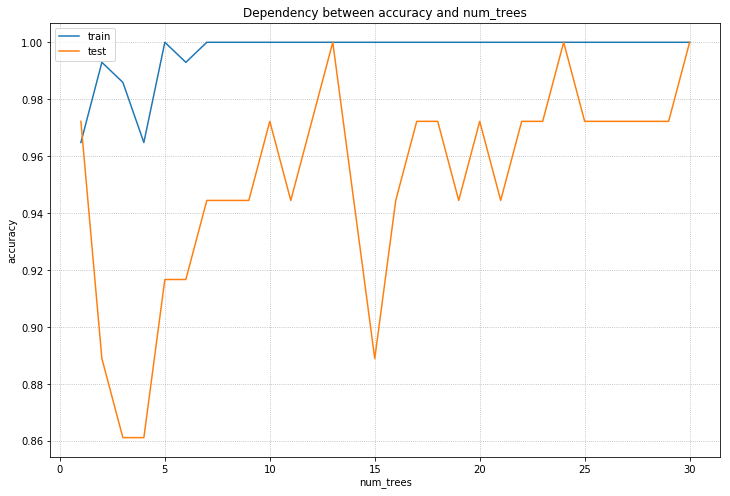

In [13]:
train_accuracy = []
test_accuracy = []

for i in range(1, 31):
    rf = RandomForest(i, max_features='sqrt')
    rf = rf.fit(X_train, y_train)
    train_accuracy += [accuracy_score(rf.predict(X_train), y_train)]
    test_accuracy += [accuracy_score(rf.predict(X_test), y_test)]
    
plt.figure(figsize=(12,8))
plt.plot(range(1, 31), train_accuracy, label='train')
plt.plot(range(1, 31), test_accuracy, label='test')
plt.xlabel('num_trees')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend(loc='best')
plt.title('Dependency between accuracy and num_trees')
plt.show()

**Вывод:** С уверенностью сказать, что в какой-то момент начинается переобучение нельзя. Но видно, что точность на тестовой выборке может падать (например, точность упала с 1 до 0.89, когда num_trees изменялся с 13 до 15).

Сравните качество работы вашей реализации RandomForest и реализации из sklearn.

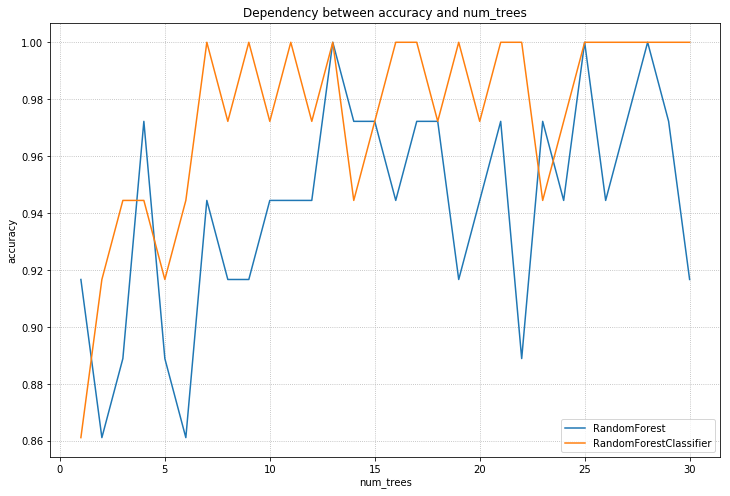

In [14]:
accuracy, sklearn_accuracy = [], []

for i in range(1, 31):
    rf = RandomForest(num_trees=i, max_features='log2', criterion='entropy')
    rf.fit(X_train, y_train)
    accuracy += [accuracy_score(y_test, rf.predict(X_test))]
    
    rf = RandomForestClassifier(n_estimators=i, max_features='log2', criterion='entropy')
    rf.fit(X_train, y_train)
    sklearn_accuracy += [accuracy_score(y_test, rf.predict(X_test))]
    
plt.figure(figsize=(12,8))
plt.plot(range(1, 31), accuracy, label='RandomForest')
plt.plot(range(1, 31), sklearn_accuracy, label='RandomForestClassifier')
plt.xlabel('num_trees')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend(loc='best')
plt.title('Dependency between accuracy and num_trees')
plt.show()

**Вывод:** В целом реализация из sklearn лучше, но можно так подобрать параметры, чтобы RandomForest давал лучший результат.

### Модификация Random Forest (15%)

Измените свою реализацию `RandomForest` так, чтобы случайное подмножество признаков выбиралось не в каждом сплите, а перед построением всего дерева. Сравните результат работы с обычным RandomForest.

In [15]:
class ModifiedRandomForest(BaseEstimator, ClassifierMixin):
    def __init__(self, num_trees, max_features, max_depth=None, criterion='gini'):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.max_features = max_features
        self.criterion = criterion
        self.trees = []
        self.features = []
    
    def fit(self, X_train, y_train):
        if isinstance(self.max_features, int):
            self.max_features = min(self.max_features, X_train.shape[1])
        elif isinstance(self.max_features, float):
            self.max_features = min(int(self.max_features * X_train.shape[1]), X_train.shape[1])
        elif self.max_features == 'sqrt':
            self.max_features = int(np.sqrt(X_train.shape[1]))
        elif self.max_features == 'log2':
            self.max_features = int(np.log2(X_train.shape[1]))
        else:
            self.max_features = X_train.shape[1]
        
        for i in range(self.num_trees):
            features = np.random.choice(range(X_train.shape[1]), size=self.max_features)
            sample_X, sample_y = bagging(X_train, y_train, len(y_train))
            clf = tree.DecisionTreeClassifier(criterion=self.criterion,
                                              max_depth=self.max_depth)
            clf.fit(sample_X.iloc[:, features], sample_y)
            self.trees += [clf]
            self.features += [features]
            
        return self
    
    def predict(self, X_test):
        y_pred = np.zeros(X_test.shape[0])
        
        for i, tree in enumerate(self.trees):
            y_pred += tree.predict(X_test.iloc[:, self.features[i]])
        
        return np.around(y_pred / self.num_trees)

Сравним результат работы RandomForest и ModifiedRandomForest.

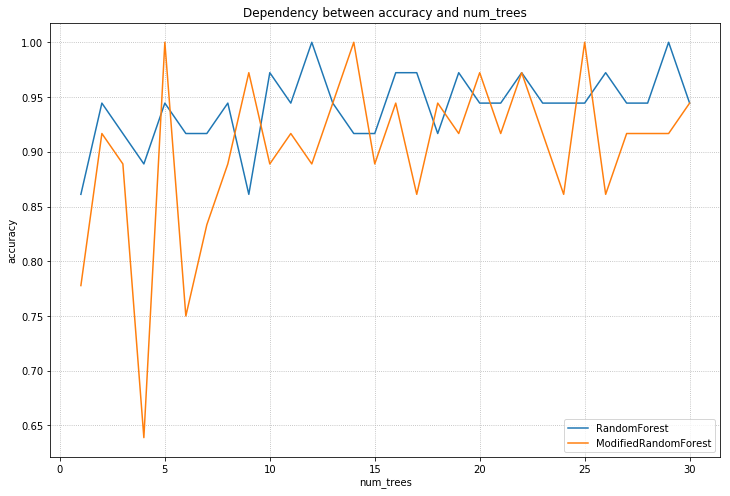

In [16]:
accuracy, modified_accuracy = [], []

for i in range(1, 31):
    rf = RandomForest(num_trees=i, max_features='log2', criterion='entropy')
    rf.fit(X_train, y_train)
    accuracy += [accuracy_score(y_test, rf.predict(X_test))]
    
    rf = ModifiedRandomForest(num_trees=i, max_features='log2', criterion='entropy')
    rf.fit(X_train, y_train)
    modified_accuracy += [accuracy_score(y_test, rf.predict(X_test))]
    
plt.figure(figsize=(12,8))
plt.plot(range(1, 31), accuracy, label='RandomForest')
plt.plot(range(1, 31), modified_accuracy, label='ModifiedRandomForest')
plt.xlabel('num_trees')
plt.ylabel('accuracy')
plt.grid(ls=':')
plt.legend(loc='best')
plt.title('Dependency between accuracy and num_trees')
plt.show()

**Вывод:** Кажется, что результаты довольно близки: часто происходит смена того, кто дает лучший результат.